Colab: https://colab.research.google.com/github/genkuroki/public/blob/main/0055/Example%20of%20Distributions.jl.ipynb

In [1]:
using Pkg: Pkg
haskey(ENV, "COLAB_GPU") && Pkg.add("Distributions")

using Random: rand!
using Distributions
using Plots
default(fmt=:png, legend=false, size=(400, 250))

haskey(ENV, "COLAB_GPU") && run(`apt-get -y install fonts-ipafont-gothic`)
default(fontfamily="ipagp")

"""
    sample_means_naive(dist, n; niters=10^4)

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して返す。
ただし、この実装では無駄なメモリアロケーションが発生する。

Example:
```jldoctest
julia> dist = Exponential(1); # 期待値1の指数分布

julia> n = 10; # 標本サイズ10

julia> sample_means_naive(dist, n; niters=10) # 標本平均が10個
10-element Vector{Float64}:
 0.7477545228347106
 1.4361102626055058
 0.9055294429107501
 1.0630035197614673
 0.9325838802514189
 0.6287737443205483
 1.5488765847122619
 1.4094079716586008
 0.3952622382268107
 0.9499173797912887
```
"""
function sample_means_naive(dist, n; niters=10^4)
    Xbar = zeros(niters)
    for i in 1:niters
        X = rand(dist, n) # 無駄なメモリアロケーションが発生
        Xbar[i] = mean(X)
    end
    Xbar
end

"""
    sample_means_single_thread(dist, n; niters=10^4)

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して返す。
シングルスレッド版。
"""
function sample_means_single_thread(dist, n; niters=10^4)
    Xbar = zeros(niters)
    Xtmp = zeros(eltype(dist), n)
    for i in 1:niters
        X = rand!(dist, Xtmp) # 無駄なメモリアロケーションの抑制
        Xbar[i] = mean(X)
    end
    Xbar
end

"""
    sample_means(dist, n; niters=10^4)

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して返す。
マルチスレッド版。
"""
function sample_means(dist, n; niters=10^4)
    Xbar = zeros(niters)
    nth = Threads.nthreads(:interactive) + Threads.nthreads(:default)
    Xtmp = [zeros(eltype(dist), n) for _ in 1:nth]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        X = rand!(dist, Xtmp[tid]) # 無駄なメモリアロケーションの抑制
        Xbar[i] = mean(X)
    end
    Xbar
end

"""
    plot_sample_means(dist, n; niters=10^5)

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して、
そのヒストグラムとそれを近似する正規分布を同時プロットする。
"""
function plot_sample_means(dist, n; niters=10^5)
    mu, sigma = mean(dist), std(dist)
    se = sigma / sqrt(n)
    Xbar = sample_means(dist, n; niters)
    histogram(Xbar; norm=true, lc=:match, alpha=0.3)
    plot!(x -> pdf(Normal(mu, se), x), mu - 5se, mu + 5se; lw=1.5)
    plot!(xguide="標本平均")
end

(@doc sample_means_naive) |> display; println()
(@doc sample_means_single_thread) |> display
(@doc sample_means) |> display
@doc plot_sample_means

```julia
sample_means_naive(dist, n; niters=10^4)
```

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して返す。 ただし、この実装では無駄なメモリアロケーションが発生する。

Example:

```jldoctest
julia> dist = Exponential(1); # 期待値1の指数分布

julia> n = 10; # 標本サイズ10

julia> sample_means_naive(dist, n; niters=10) # 標本平均が10個
10-element Vector{Float64}:
 0.7477545228347106
 1.4361102626055058
 0.9055294429107501
 1.0630035197614673
 0.9325838802514189
 0.6287737443205483
 1.5488765847122619
 1.4094079716586008
 0.3952622382268107
 0.9499173797912887
```


```julia
sample_means_single_thread(dist, n; niters=10^4)
```

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して返す。 シングルスレッド版。


```julia
sample_means(dist, n; niters=10^4)
```

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して返す。 マルチスレッド版。


```julia
plot_sample_means(dist, n; niters=10^5)
```

確率分布 `dist` のサイズ `n` のランダムな標本の平均を `niters` 個生成して、 そのヒストグラムとそれを近似する正規分布を同時プロットする。


In [2]:
# sample_means_naiveでは無駄なメモリアロケーションが発生して遅くなる。
@time sample_means_naive(Exponential(1), 10; niters=10^7);
@time sample_means_naive(Exponential(1), 10; niters=10^7);
@time sample_means_naive(Exponential(1), 10; niters=10^7);
@time sample_means_naive(Exponential(1), 10; niters=10^7);
@time sample_means_naive(Exponential(1), 10; niters=10^7);

  1.315553 seconds (20.00 M allocations: 1.416 GiB, 23.66% gc time)
  1.276047 seconds (20.00 M allocations: 1.416 GiB, 19.12% gc time)
  1.275408 seconds (20.00 M allocations: 1.416 GiB, 18.17% gc time)
  1.293034 seconds (20.00 M allocations: 1.416 GiB, 18.11% gc time)
  1.320136 seconds (20.00 M allocations: 1.416 GiB, 18.74% gc time)


In [3]:
# シングルスレッド版
@time sample_means_single_thread(Exponential(1), 10; niters=10^7);
@time sample_means_single_thread(Exponential(1), 10; niters=10^7);
@time sample_means_single_thread(Exponential(1), 10; niters=10^7);
@time sample_means_single_thread(Exponential(1), 10; niters=10^7);
@time sample_means_single_thread(Exponential(1), 10; niters=10^7);

  0.861944 seconds (5 allocations: 76.294 MiB, 0.70% gc time)
  0.799191 seconds (5 allocations: 76.294 MiB)
  0.863938 seconds (5 allocations: 76.294 MiB, 2.10% gc time)
  0.834712 seconds (5 allocations: 76.294 MiB, 1.20% gc time)
  0.843006 seconds (5 allocations: 76.294 MiB, 0.84% gc time)


In [4]:
# マルチスレッド版
@time sample_means(Exponential(1), 10; niters=10^7);
@time sample_means(Exponential(1), 10; niters=10^7);
@time sample_means(Exponential(1), 10; niters=10^7);
@time sample_means(Exponential(1), 10; niters=10^7);
@time sample_means(Exponential(1), 10; niters=10^7);

  0.206356 seconds (36.03 k allocations: 78.083 MiB, 2.67% gc time, 156.84% compilation time)
  0.185325 seconds (218 allocations: 76.308 MiB, 3.55% gc time)
  0.229563 seconds (219 allocations: 76.308 MiB, 22.59% gc time)
  0.242479 seconds (220 allocations: 76.308 MiB, 30.33% gc time)
  0.178901 seconds (213 allocations: 76.308 MiB)


In [5]:
Xbar = sample_means_naive(Exponential(1), 10; niters=10) # 期待値1の指数分布のサイズ10の標本平均を10個

10-element Vector{Float64}:
 0.5272144408310036
 1.6792157994058852
 0.8168588382663406
 1.4815222513424957
 0.7585674485259059
 1.1431821563660205
 0.7248190265910547
 1.0015203634491114
 1.1093730168731983
 0.8435976995619165

In [6]:
Xbar = sample_means_single_thread(Exponential(1), 10; niters=10) # 期待値1の指数分布のサイズ10の標本平均を10個

10-element Vector{Float64}:
 1.4325585681469737
 0.8039690461836153
 1.23275163747521
 1.1455149921689032
 1.1003731746116945
 0.8619501873406005
 0.5169514308971772
 0.5412182356867116
 0.5093371747237352
 0.4446014602263676

In [7]:
Xbar = sample_means(Exponential(1), 10; niters=10) # 期待値1の指数分布のサイズ10の標本平均を10個

10-element Vector{Float64}:
 0.9806138849774166
 0.9777231512362338
 0.6686852339647291
 1.3789657048514377
 1.1225932574389106
 1.3810141605973745
 1.1100783494337634
 1.2356095127081361
 1.2411404582528376
 0.6141780808824684

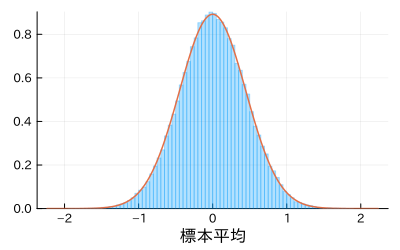

In [8]:
plot_sample_means(Normal(), 5)

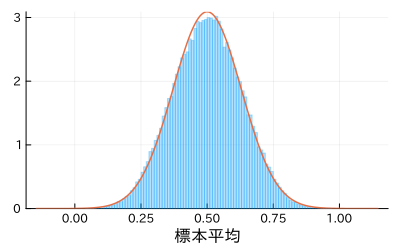

In [9]:
plot_sample_means(Uniform(), 5)

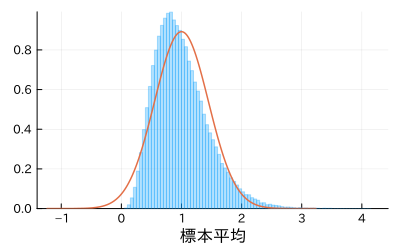

In [10]:
plot_sample_means(Exponential(1), 5)

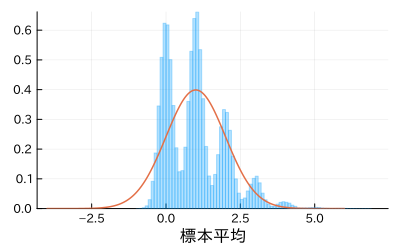

In [11]:
plot_sample_means(MixtureModel([Normal(), Normal(20)], [0.95, 0.05]), 20)